<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agenteval_cq_math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrating the `AgentEval` framework using the task of solving math problems as an example

This notebook aims to demonstrate how to `AgentEval` implemented through [AutoGen](https://github.com/microsoft/autogen) works in an offline scenario, where we use a math problem-solving task as an example. 
`AgentEval` consists of two key steps:

- `generate_criteria`: This is an LLM-based function that generates a list of criteria $(c_1, \dots, c_n)$ to help to evaluate a utility given task.

- `quantify_criteria`: This function quantifies the performance of any sample task based on the criteria generated in the `generate_criteria` step in the following way: $(c_1=a_1, \dots, c_n=a_n)$

![AgentEval](../website/blog/2023-11-20-AgentEval/img/agenteval-CQ.png)

For more detailed explanations, please refer to the accompanying [blog post](https://microsoft.github.io/autogen/blog/2023/11/20/AgentEval)

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install pyautogen, Docker, and OpenAI:


In [1]:
%pip install "pyautogen>=0.2.3" docker
%pip install scipy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Set your API Endpoint
* The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file. It first looks for an environment variable with a specified name. The value of the environment variable needs to be a valid json string. If that variable is not found, it looks for a json file with the same name. It filters the configs by filter_dict.

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.


In [2]:
import json
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import autogen
from autogen.agentchat.contrib.agent_eval.critic_agent import CriticAgent
from autogen.agentchat.contrib.agent_eval.quantifier_agent import QuantifierAgent
from autogen.agentchat.contrib.agent_eval.agent_eval import generate_criteria, quantify_criteria
from autogen.agentchat.contrib.agent_eval.criterion import Criterion
from autogen.agentchat.contrib.agent_eval.task import Task

config_list = autogen.config_list_from_json("OAI_CONFIG_LIST")

ModuleNotFoundError: No module named 'critic_agent'

# Run the Critic

To run the critic, we need a couple of math problem examples. One of them failed to solve the problem successfully, given in `agenteval-in-out/response_failed.txt`, and the other one was solved successfully, i.e., `agenteval-in-out/response_successful.txt`.

In [ ]:
def remove_ground_truth(test_case):
    test_details = json.loads(test_case)
    # need to remove the ground truth from the test details
    correctness = test_details.pop("is_correct", None)
    test_details.pop("correct_ans", None)
    test_details.pop("check_result", None)
    return test_details, correctness


# Reading one successful and one failed example of the task
success_str = open("../test/test_files/agenteval-in-out/samples/sample_math_response_successful.txt", "r").read()
response_successful = remove_ground_truth(success_str)[0]
failed_str = open("../test/test_files/agenteval-in-out/samples/sample_math_response_failed.txt", "r").read()
response_failed = remove_ground_truth(failed_str)[0]

task = Task.parse_json_str(
    json.dumps(
        {
            "name": "Math problem solving",
            "description": "Given any question, the system needs to solve the problem as consisely and accurately as possible",
            "successful_response": response_successful,
            "failed_response": response_failed,
        }
    )
)

criteria = generate_criteria(task=task, llm_config={"config_list": config_list}, max_round=8)

critic_user (to chat_manager):



Task: Math problem solving.
    Task description: Given any question, the system needs to solve the problem as consisely and accurately as possible
    Task successful example: {'problem': 'What is the sum of all the distinct positive two-digit factors of 144?', 'level': 'Level 5', 'type': 'Number Theory', 'solution': 'Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$', 'problem_id': '0', 'response_with_ans': 'To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere\'s a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_digit_factors.append(i)\n\nsum_of_factors = 

# The Criteria
Now, we print the designed criteria for assessing math problems. 

In [ ]:
current_task_name = "_".join(task.name.split()).lower()
cr_file = open(f"../test/test_files/agenteval-in-out/{current_task_name}_criteria.json", "w")
cr_file.write(Criterion.write_json(criteria))
cr_file.close()

*Note :* You can also define and use your own criteria in order to feed into the quantifier.

# The `QuantifierAgent`

Once we have the criteria, we need to quantify a new sample based on the designed criteria and its accepted values. This will be done through `quantify_criteria` from agent_eval. 
Again, you can use your own defined criteria in `criteria_file`.

In [ ]:
criteria_file = f"../test/test_files/agenteval-in-out/{current_task_name}_criteria.json"
criteria = open(criteria_file, "r").read()
criteria = Criterion.parse_json_str(criteria)

## Running the quantifier on a single test case

Here, we run the quantifier on a single math problem test case, `sample_test_case.json`, for demonstration.

In [ ]:
test_case = open("../test/test_files/agenteval-in-out/samples/sample_test_case.json", "r").read()
test_case, ground_truth = remove_ground_truth(test_case)
quantifier_output = quantify_criteria(
    llm_config={"config_list": config_list},
    criteria=criteria,
    task=task,
    test_case=test_case,
    ground_truth=ground_truth,
)
print("actual correctness:", quantifier_output["actual_success"])
print("predicted correctness:\n", quantifier_output["estimated_performance"])

quantifier_user (to quantifier):

Task: Math problem solving.
    Task description: Given any question, the system needs to solve the problem as consisely and accurately as possible
    Task successful example: {'problem': 'What is the sum of all the distinct positive two-digit factors of 144?', 'level': 'Level 5', 'type': 'Number Theory', 'solution': 'Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$', 'problem_id': '0', 'response_with_ans': 'To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere\'s a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_digit_fact

# Run `AgentEval` on the logs

In the example below, log_path points to the sample logs folder to run the quantifier. The current sample belongs to the prealgebra category which will be downloaded from [here](https://github.com/julianakiseleva/autogen/tree/agenteval/test/test_files/agenteval-in-out/samples).
In case you want to replicate the results described in the blog post, you can download all the logs for math problems using the following [link](https://github.com/julianakiseleva/autogen/tree/agenteval/model-logs/math-problems/agentchat). 

In [ ]:
# You can set your own log path - we also limited the number of samples to avoid additional costs.
# By removing the condition about limitations on the number of samples per category, you can run it on all 120 problems

log_path = "../test/test_files/agenteval-in-out/agentchat_results/"

# The file is no longer in the repo, we can download it from an older commit
!wget https://github.com/julianakiseleva/autogen/raw/ddabd4f0e7c13a50e33cf8462e79358666371477/test/test_files/agenteval-in-out/prealgebra.zip
!unzip -o prealgebra.zip -d {log_path}
!rm  prealgebra.zip

assert Path(log_path).exists(), f"The log path '{log_path}' does not exist."

--2024-04-17 22:07:57--  https://github.com/julianakiseleva/autogen/raw/ddabd4f0e7c13a50e33cf8462e79358666371477/test/test_files/agenteval-in-out/prealgebra.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 

302 Found
Location: https://raw.githubusercontent.com/julianakiseleva/autogen/ddabd4f0e7c13a50e33cf8462e79358666371477/test/test_files/agenteval-in-out/prealgebra.zip [following]
--2024-04-17 22:07:58--  https://raw.githubusercontent.com/julianakiseleva/autogen/ddabd4f0e7c13a50e33cf8462e79358666371477/test/test_files/agenteval-in-out/prealgebra.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28567 (28K) [application/zip]
Saving to: ‘prealgebra.zip’

prealgebra.zip      100%[===================>]  27.90K  --.-KB/s    in 0.002s  

2024-04-17 22:07:58 (11.3 MB/s) - ‘prealgebra.zip’ saved [28567/28567]

Archive:  prealgebra.zip
  inflating: ../test/test_files/agenteval-in-out/agentchat_results/prealgebra/9.json  
  inflating: ../test/test_files/agenteval-in-

In [ ]:
criteria_file = "../test/test_files/agenteval-in-out/samples/sample_math_criteria.json"
criteria = Criterion.parse_json_str(open(criteria_file, "r").read())
outcome = {}

for prefix in os.listdir(log_path):
    for file_name in os.listdir(log_path + "/" + prefix):
        gameid = prefix + "_" + file_name
        if file_name.split(".")[-1] == "json":
            test_case, ground_truth = remove_ground_truth(open(log_path + "/" + prefix + "/" + file_name, "r").read())
            quantifier_output = quantify_criteria(
                llm_config={"config_list": config_list},
                criteria=criteria,
                task=task,
                test_case=test_case,
                ground_truth=ground_truth,
            )
            outcome[gameid] = quantifier_output

# store the evaluated problems
with open("../test/test_files/agenteval-in-out/evaluated_problems.json", "w") as file:
    json.dump(outcome, file, indent=2)  # use `json.loads` to do the reverse

quantifier_user (to quantifier):

Task: Math problem solving.
    Task description: Given any question, the system needs to solve the problem as consisely and accurately as possible
    Task successful example: {'problem': 'What is the sum of all the distinct positive two-digit factors of 144?', 'level': 'Level 5', 'type': 'Number Theory', 'solution': 'Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$', 'problem_id': '0', 'response_with_ans': 'To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere\'s a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_digit_fact

quantifier (to quantifier_user):

{
  "Problem Interpretation": "completely accurate",
  "Mathematical Methodology": "mostly effective",
  "Calculation Correctness": "completely incorrect",
  "Explanation Clarity": "very clear",
  "Code Efficiency": "not applicable",
  "Code Correctness": "not applicable"
}

--------------------------------------------------------------------------------
quantifier_user (to quantifier):

Task: Math problem solving.
    Task description: Given any question, the system needs to solve the problem as consisely and accurately as possible
    Task successful example: {'problem': 'What is the sum of all the distinct positive two-digit factors of 144?', 'level': 'Level 5', 'type': 'Number Theory', 'solution': 'Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$', 'problem_id': '0', 'response_with_ans': 'To find the sum of all the distin

## Plotting the estimated performance

Here you can find an example of how to visualize the obtained result in the histogram form (similar to the one in the blog post).

In [ ]:
# computing average and 95% interval for failed and successful cases on all criteria
try:
    # convert the criteria to dict type if it is already not
    dictionary_for_eval = eval(open(criteria_file, "r").read())
except:  # noqa: E722
    pass

criteria = list(dictionary_for_eval.keys())
nl2int = {}
for criterion in dictionary_for_eval:
    score = 0
    for v in dictionary_for_eval[criterion]["accepted_values"]:
        nl2int[v] = score
        score += 1
print(nl2int)

average_s = {}
average_f = {}

conf_interval_s = {}
conf_interval_f = {}

for criterion in criteria:
    task = {"s": [], "f": []}

    for game in outcome:
        try:
            tmp_dic = eval(outcome[game]["estimated_performance"])
            if outcome[game]["actual_success"] == "false":
                task["f"].append(nl2int[tmp_dic[criterion]])
            else:
                task["s"].append(nl2int[tmp_dic[criterion]])
        except:  # noqa: E722
            pass

    average_f[criterion] = np.mean(task["f"])
    average_s[criterion] = np.mean(task["s"])

    conf_interval_s[criterion] = stats.norm.interval(0.95, loc=np.mean(task["s"]), scale=stats.sem(task["s"]))
    conf_interval_f[criterion] = stats.norm.interval(0.95, loc=np.mean(task["f"]), scale=stats.sem(task["f"]))

{'completely off': 0, 'slightly relevant': 1, 'relevant': 2, 'mostly accurate': 3, 'completely accurate': 4, 'inappropriate': 0, 'barely adequate': 1, 'adequate': 2, 'mostly effective': 3, 'completely effective': 4, 'completely incorrect': 0, 'mostly incorrect': 1, 'neither': 2, 'mostly correct': 3, 'completely correct': 4, 'not at all clear': 0, 'slightly clear': 1, 'moderately clear': 2, 'very clear': 3, 'completely clear': 4, 'not at all efficient': 0, 'slightly efficient': 1, 'moderately efficient': 2, 'very efficient': 3, 'extremely efficient': 4, 'partly correct': 2}


/home/vscode/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vscode/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/vscode/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/vscode/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/vscode/.local/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/vscode/.local/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encoun

The final plot would be saved in `../test/test_files/agenteval-in-out/estimated_performance.png`

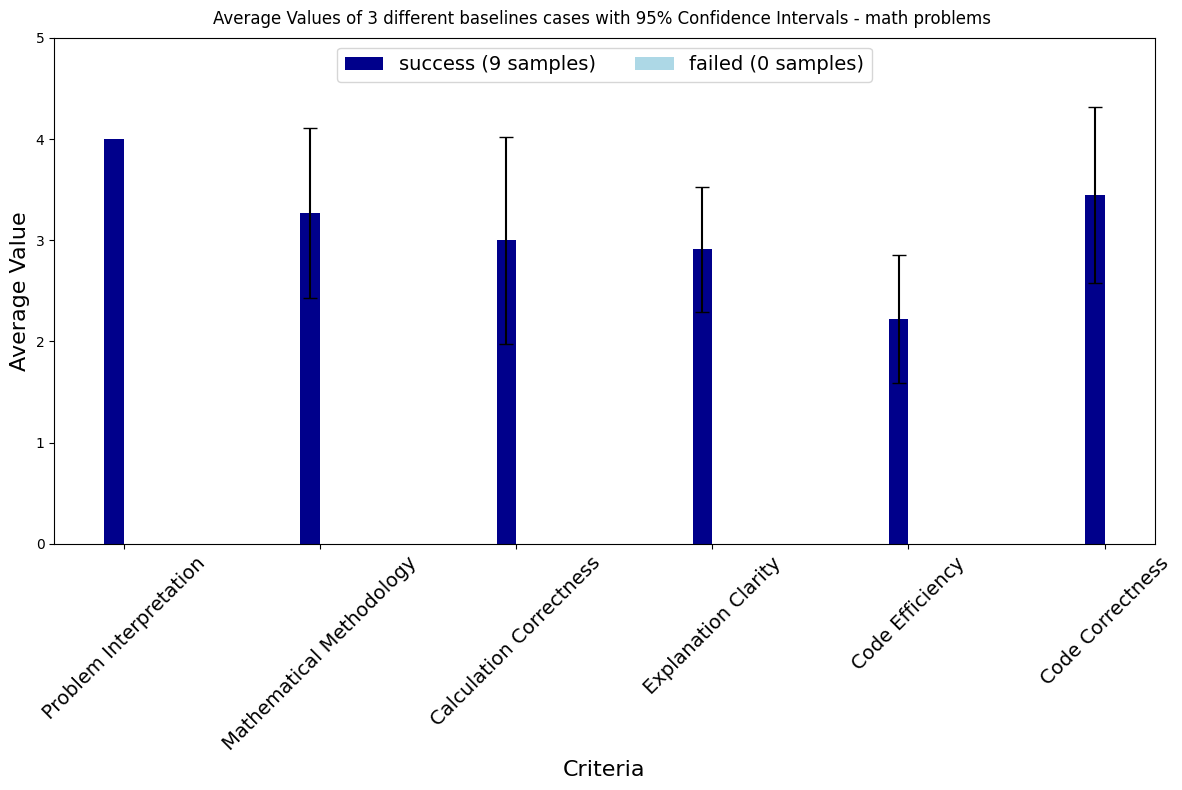

In [ ]:
# Create a bar plot with error bars for the average values of "s" and "f" for each criterion

plt.figure(figsize=(12, 8))
bar_width = 0.1
index = np.arange(len(criteria))


plt.bar(
    index,
    list(average_s.values()),
    bar_width,
    label=f"success ({len(task['s'])} samples)",
    color="darkblue",
    yerr=[(avg - conf_interval_s[key][0]) for key, avg in average_s.items()],
    capsize=5,
)
plt.bar(
    index + bar_width,
    list(average_f.values()),
    bar_width,
    label=f"failed ({len(task['f'])} samples)",
    color="lightblue",
    yerr=[(avg - conf_interval_f[key][0]) for key, avg in average_f.items()],
    capsize=5,
)

plt.xlabel("Criteria", fontsize=16)
plt.ylabel("Average Value", fontsize=16)
plt.title(
    "Average Values of 3 different baselines cases with 95% Confidence Intervals - math problems ", fontsize=12, pad=10
)  # Adjust titlepad to move the title further above
plt.xticks(index + bar_width / 2, criteria, rotation=45, fontsize=14)
plt.legend(loc="upper center", fontsize=14, bbox_to_anchor=(0.5, 1), ncol=3)  # Adjust legend placement and ncol
plt.tight_layout()  # Adjust subplot parameters to fit the labels
plt.ylim(0, 5)
plt.savefig("../test/test_files/agenteval-in-out/estimated_performance.png")
plt.show()